In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines() if '__main__' in log]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [26]:
df = df.rename(columns={'modelconf.layersconf.Random_Flip.mode':'Random_Flip', 'modelconf.layersconf.Random_Brightness.factor':'Random_Brightness', 'modelconf.layersconf.Random_Contrast.factor':'Random_Contrast'})
df.epoch = df.epoch.astype('uint8')
df.Random_Brightness = df.Random_Brightness.astype('float64')
df.Random_Contrast = df.Random_Contrast.astype('float64')
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13180 entries, 0 to 13179
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modelconf            13180 non-null  object 
 1   Random_Flip          13180 non-null  object 
 2   Random_Brightness    13180 non-null  float64
 3   Random_Contrast      13180 non-null  float64
 4   epoch                13180 non-null  uint8  
 5   Train Accuracy       11160 non-null  float64
 6   Train Loss           11160 non-null  float64
 7   Validation Accuracy  11160 non-null  float64
 8   Validation Loss      11160 non-null  float64
dtypes: float64(6), object(2), uint8(1)
memory usage: 836.7+ KB


In [3]:
desc = df[df.epoch > 6].groupby(['Random_Flip','Random_Brightness', 'Random_Contrast']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [19]:
df.columns

Index(['modelconf', 'Random_Flip', 'Random_Brightness', 'Random_Contrast',
       'epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy',
       'Validation Loss'],
      dtype='object')

In [25]:
df.reset_index(drop=True)

,modelconf,Random_Flip,Random_Brightness,Random_Contrast,epoch,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,3LayerConv_data_aug,horizontal,0.4,0.1,1,0.866652,0.363793,0.592981,1.023173
1,3LayerConv_data_aug,horizontal,0.4,0.1,2,0.973503,0.109427,0.585745,1.599792
2,3LayerConv_data_aug,horizontal,0.4,0.1,3,0.989875,0.062872,0.671852,1.477684
3,3LayerConv_data_aug,horizontal,0.4,0.1,4,0.993106,0.045921,0.611794,1.959324
4,3LayerConv_data_aug,horizontal,0.4,0.1,5,0.991598,0.051600,0.659913,1.952404
...,...,...,...,...,...,...,...,...,...
13175,3LayerConv_data_aug,horizontal_and_vertical,0.3,0.2,16,0.999785,0.009400,0.492764,7.200599
13176,3LayerConv_data_aug,horizontal_and_vertical,0.3,0.2,17,1.000000,0.007729,0.488423,6.993142
13177,3LayerConv_data_aug,horizontal_and_vertical,0.3,0.2,18,0.998707,0.010399,0.471418,5.536810
13178,3LayerConv_data_aug,horizontal_and_vertical,0.3,0.2,19,0.998707,0.009001,0.477569,7.465049


<Axes: xlabel='Train Loss', ylabel='Train Accuracy'>

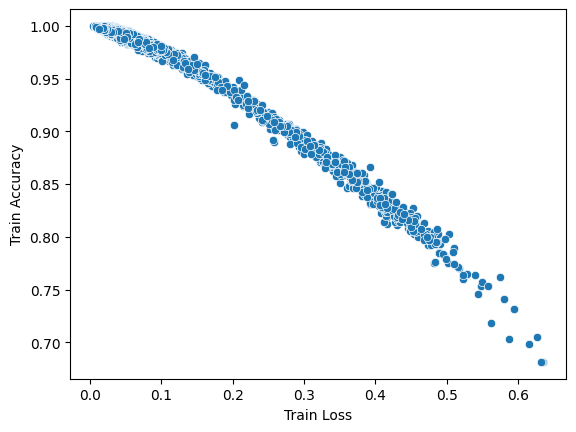

In [27]:
sns.scatterplot(data=df,
                x = 'Train Loss',
                y='Train Accuracy')

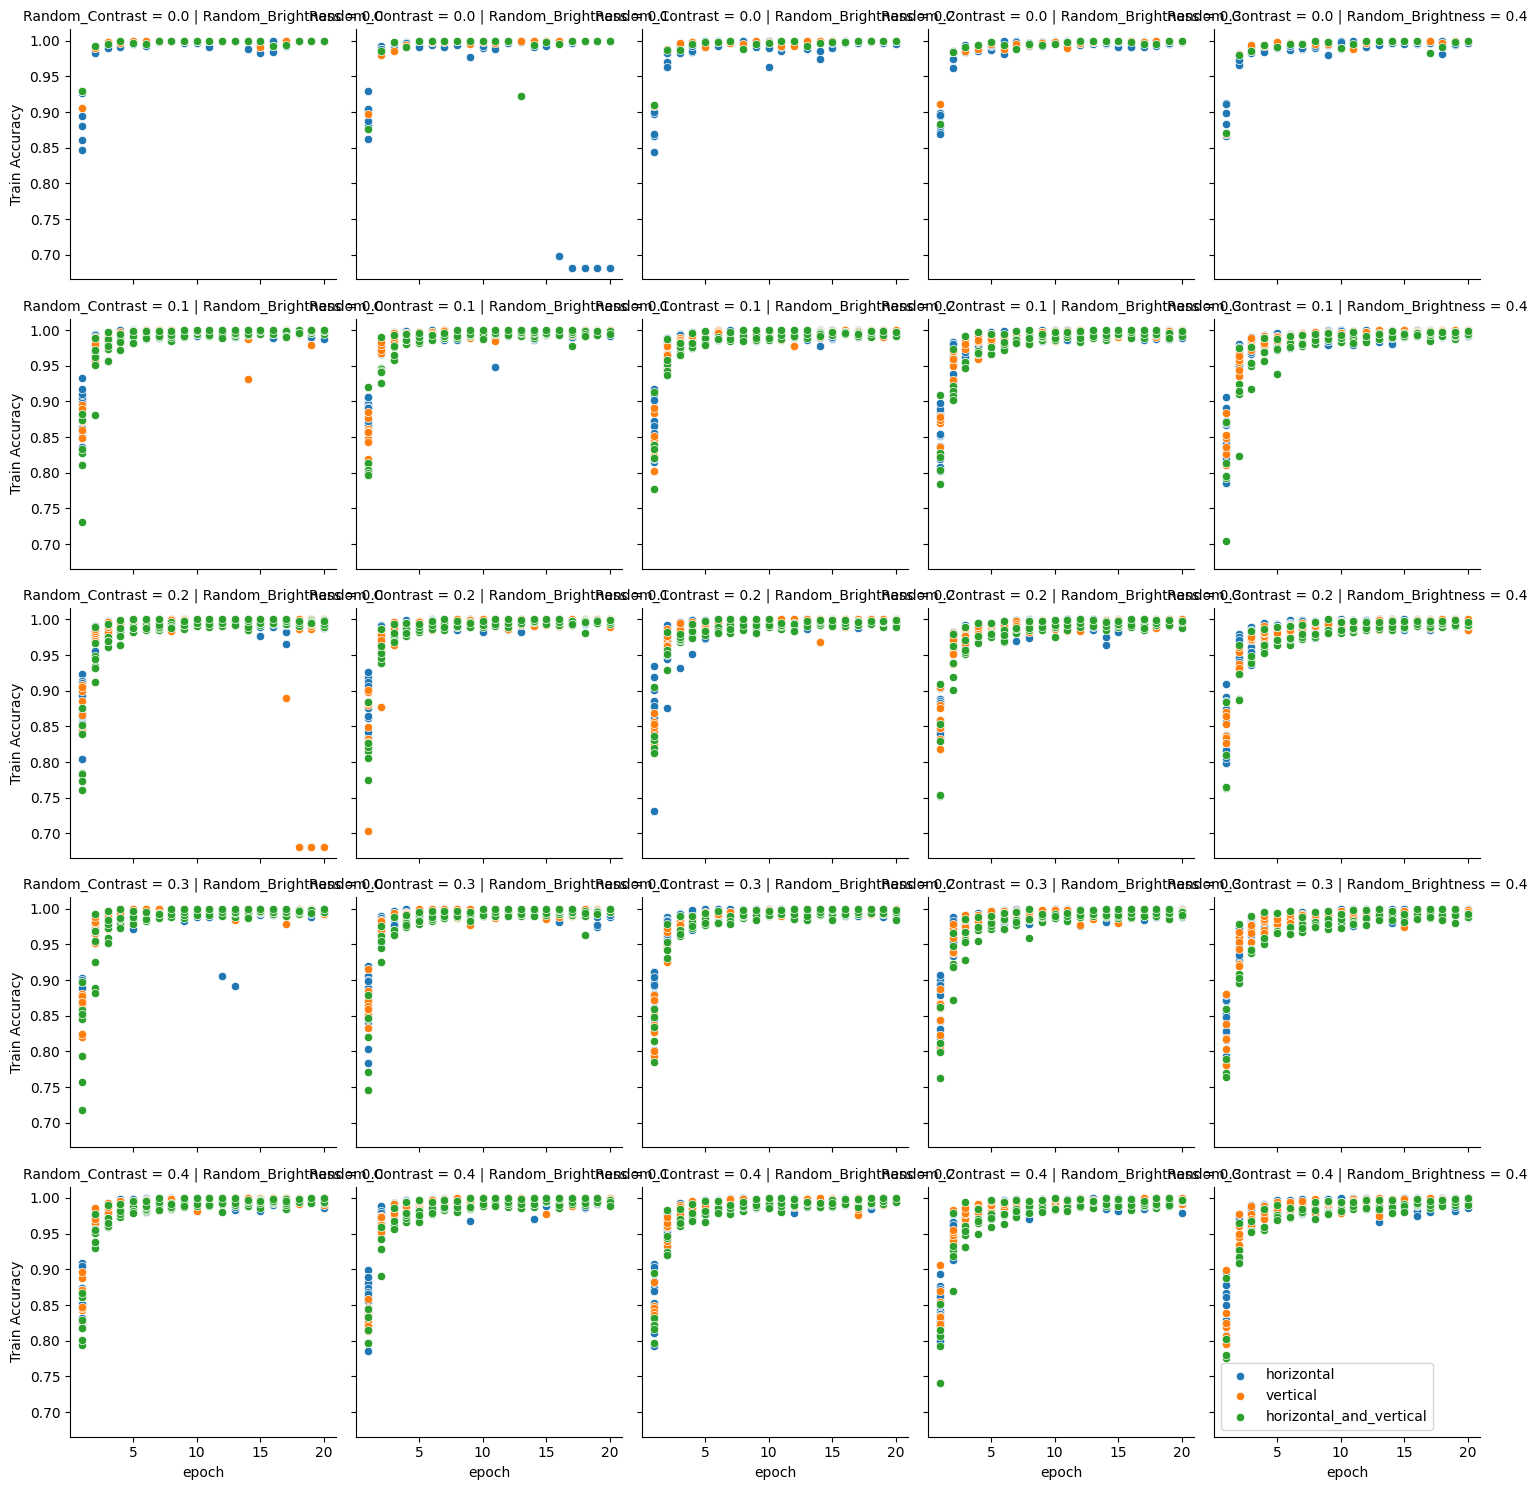

In [28]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Train Accuracy')
plt.tight_layout()
plt.legend()

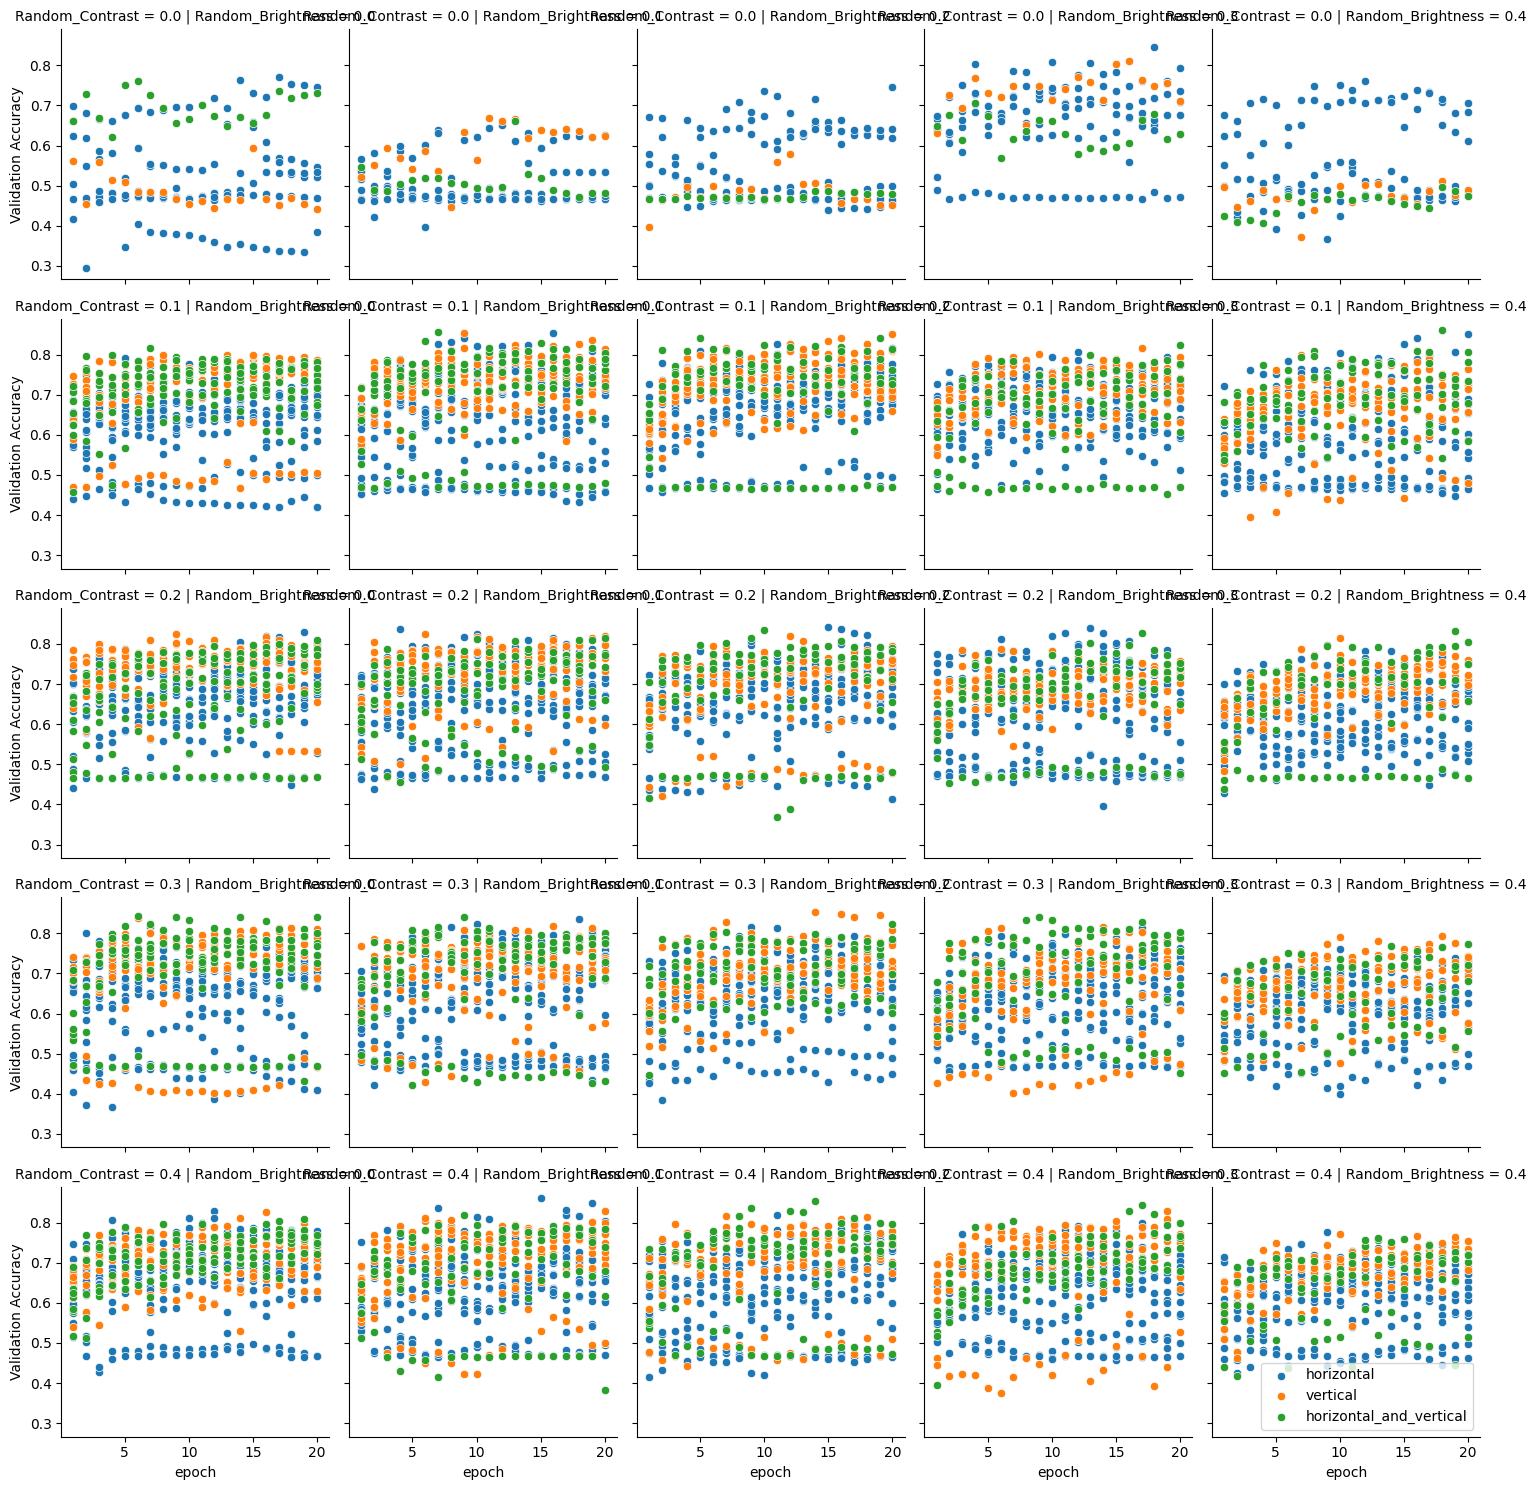

In [29]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()

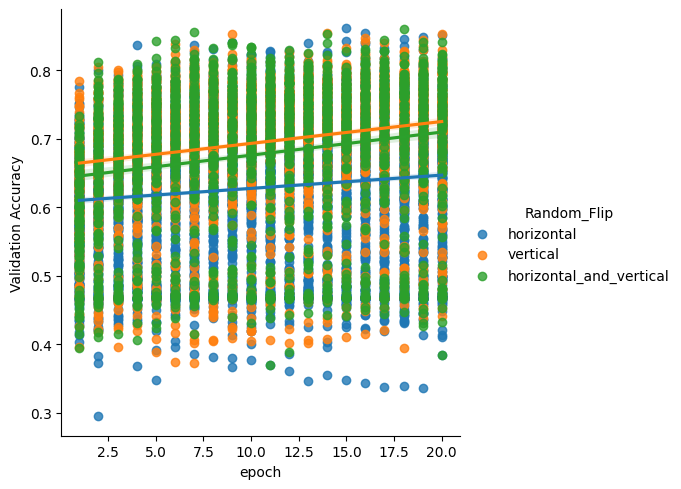

In [31]:
sns.lmplot(data=df,
           x='epoch',
           y='Validation Accuracy',
           hue='Random_Flip')

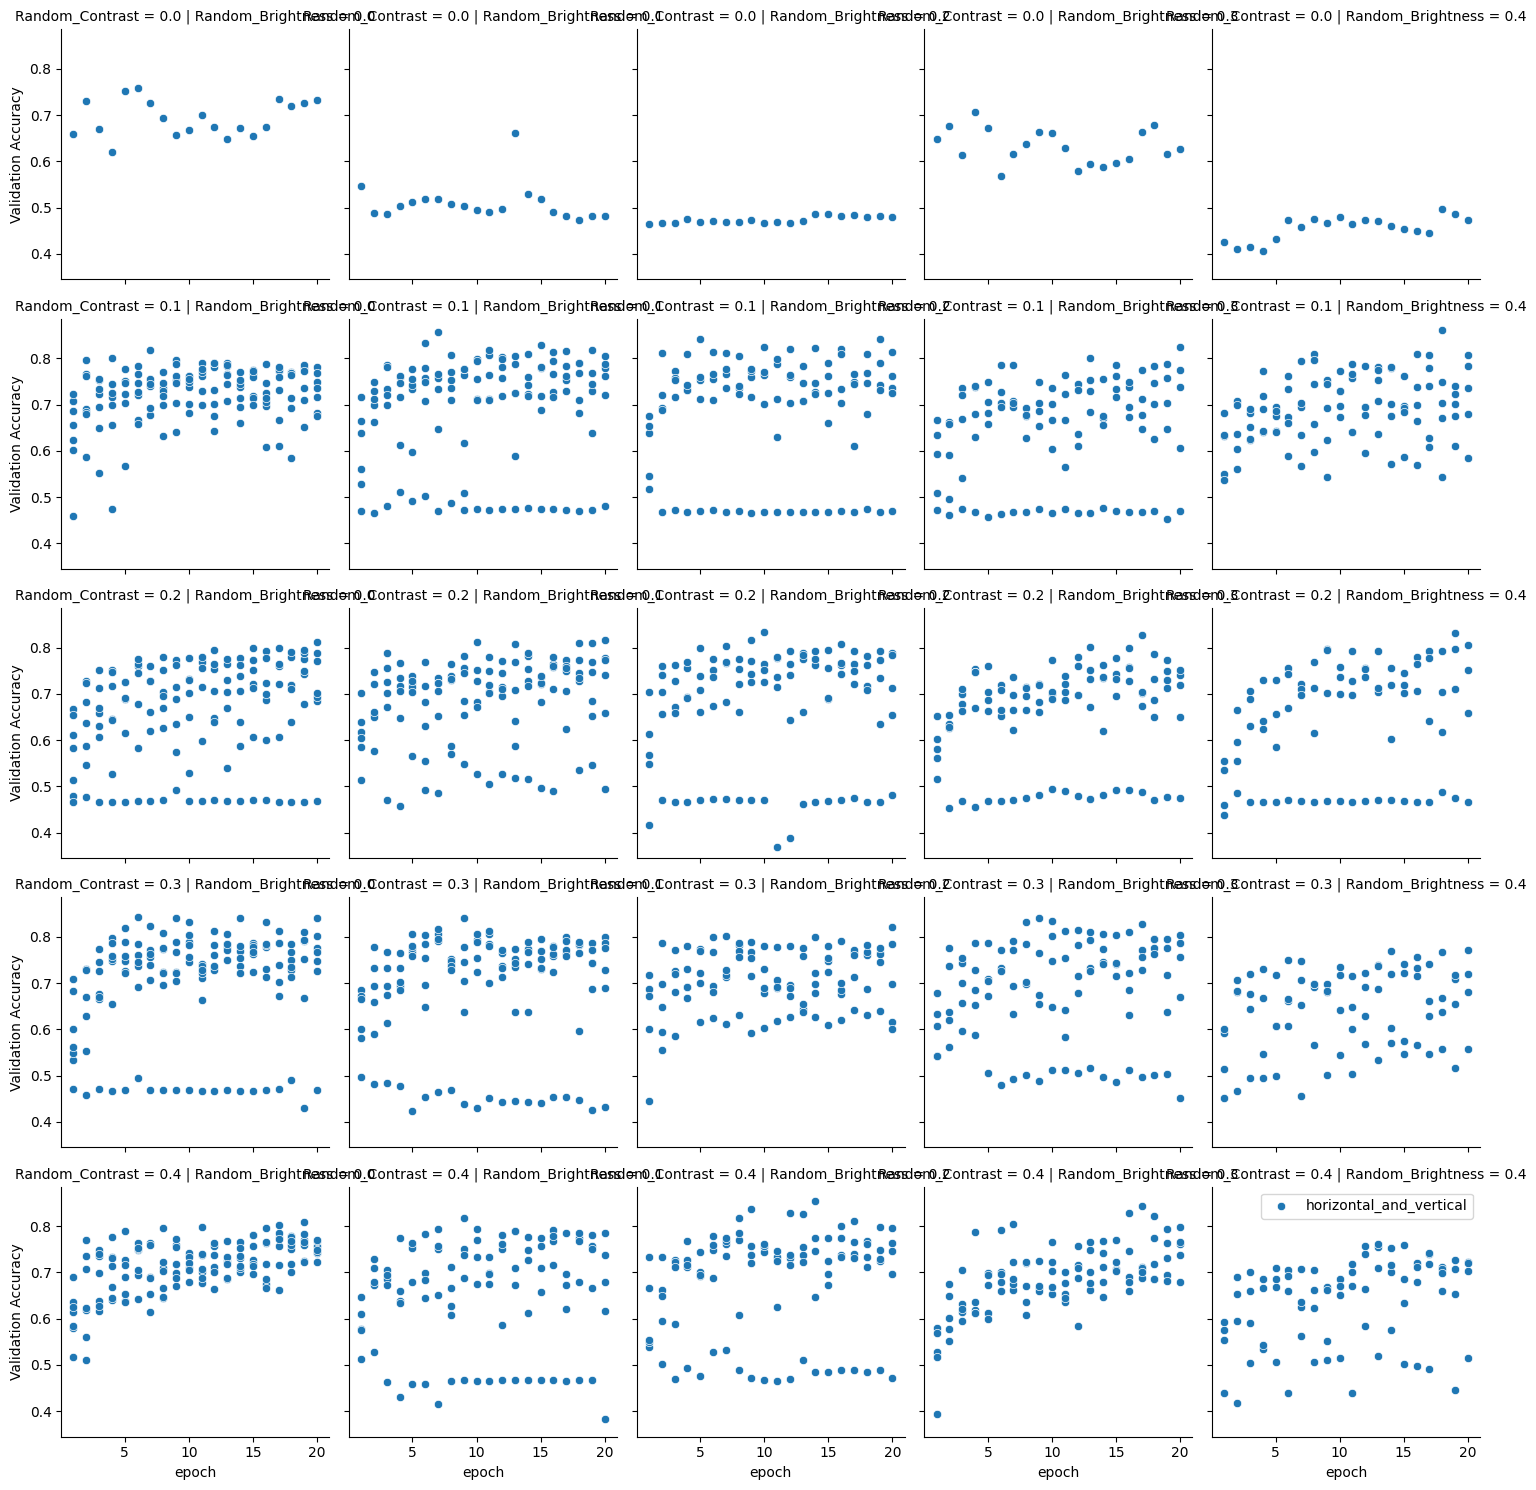

In [32]:
g = sns.FacetGrid(df[df.Random_Flip == 'horizontal_and_vertical'], col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()